In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
from FlagEmbedding import BGEM3FlagModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
model_name = "onlplab/alephbert-base"
alephbert_model = AutoModel.from_pretrained(model_name, add_pooling_layer=False)
alephbert_tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
bgem3_model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Admin\PycharmProjects\KaleidooProject\.venv\lib\site-packages\FlagEmbedding\BGE_M3\modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colbert_state_dict

In [5]:
def get_alephbert_embedding(text):
    inputs = alephbert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = alephbert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def get_bgem3_embedding(text):
    return bgem3_model.encode([text], batch_size=1, max_length=8192)['dense_vecs'][0]

def compute_similarity(emb1, emb2):
    return cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]

In [6]:
# Test texts (Hebrew and English)
texts = [
    "מה שלומך היום? אני מקווה שהכל בסדר.",
    "היי, מה נשמע? איך עבר עליך השבוע? אני ממש נהניתי מהטיול שלנו לצפון בסוף השבוע שעבר.",
    "פונקציית הפעלה ReLU מוגדרת כ-f(x) = max(0, x).",
    "בלמידת מכונה, רשתות נוירונים עמוקות הן ארכיטקטורות מורכבות המורכבות משכבות רבות של נוירונים מלאכותיים.",
    "How are you today? I hope everything is fine.",
    "Hey, what's up? How was your week? I really enjoyed our trip to the north last weekend.",
    "The ReLU activation function is defined as f(x) = max(0, x).",
    "In machine learning, Deep Neural Networks are complex architectures composed of many layers of artificial neurons."
]

text_types = ['Short Conversational', 'Long Conversational', 'Short Technical', 'Long Technical'] * 2
languages = ['Hebrew'] * 4 + ['English'] * 4

In [7]:
import time
results = []
for text, text_type, language in zip(texts, text_types, languages):
    # AlephBERT
    start_time = time.time()
    alephbert_embedding = get_alephbert_embedding(text)
    alephbert_time = time.time() - start_time

    # BGEM3
    start_time = time.time()
    bgem3_embedding = get_bgem3_embedding(text)
    bgem3_time = time.time() - start_time

    results.append({
        'Text Type': text_type,
        'Language': language,
        'Text Length': len(text),
        'AlephBERT Time': alephbert_time,
        'BGEM3 Time': bgem3_time,
        'AlephBERT Embedding': alephbert_embedding,
        'BGEM3 Embedding': bgem3_embedding
    })

df_results = pd.DataFrame(results)

In [8]:
print("AlephBERT Similarities:")
for i in range(len(texts)):
    for j in range(i+1, len(texts)):
        emb1 = df_results.iloc[i]['AlephBERT Embedding']
        emb2 = df_results.iloc[j]['AlephBERT Embedding']
        similarity = compute_similarity(emb1, emb2)
        print(f"{text_types[i]} ({languages[i]}) and {text_types[j]} ({languages[j]}): {similarity:.4f}")

print("\nBGEM3 Similarities:")
for i in range(len(texts)):
    for j in range(i+1, len(texts)):
        emb1 = df_results.iloc[i]['BGEM3 Embedding']
        emb2 = df_results.iloc[j]['BGEM3 Embedding']
        similarity = compute_similarity(emb1, emb2)
        print(f"{text_types[i]} ({languages[i]}) and {text_types[j]} ({languages[j]}): {similarity:.4f}")


AlephBERT Similarities:
Short Conversational (Hebrew) and Long Conversational (Hebrew): 0.7968
Short Conversational (Hebrew) and Short Technical (Hebrew): 0.5936
Short Conversational (Hebrew) and Long Technical (Hebrew): 0.5576
Short Conversational (Hebrew) and Short Conversational (English): 0.6576
Short Conversational (Hebrew) and Long Conversational (English): 0.6425
Short Conversational (Hebrew) and Short Technical (English): 0.6121
Short Conversational (Hebrew) and Long Technical (English): 0.6084
Long Conversational (Hebrew) and Short Technical (Hebrew): 0.5855
Long Conversational (Hebrew) and Long Technical (Hebrew): 0.5643
Long Conversational (Hebrew) and Short Conversational (English): 0.7057
Long Conversational (Hebrew) and Long Conversational (English): 0.7738
Long Conversational (Hebrew) and Short Technical (English): 0.6101
Long Conversational (Hebrew) and Long Technical (English): 0.6482
Short Technical (Hebrew) and Long Technical (Hebrew): 0.7051
Short Technical (Hebrew)

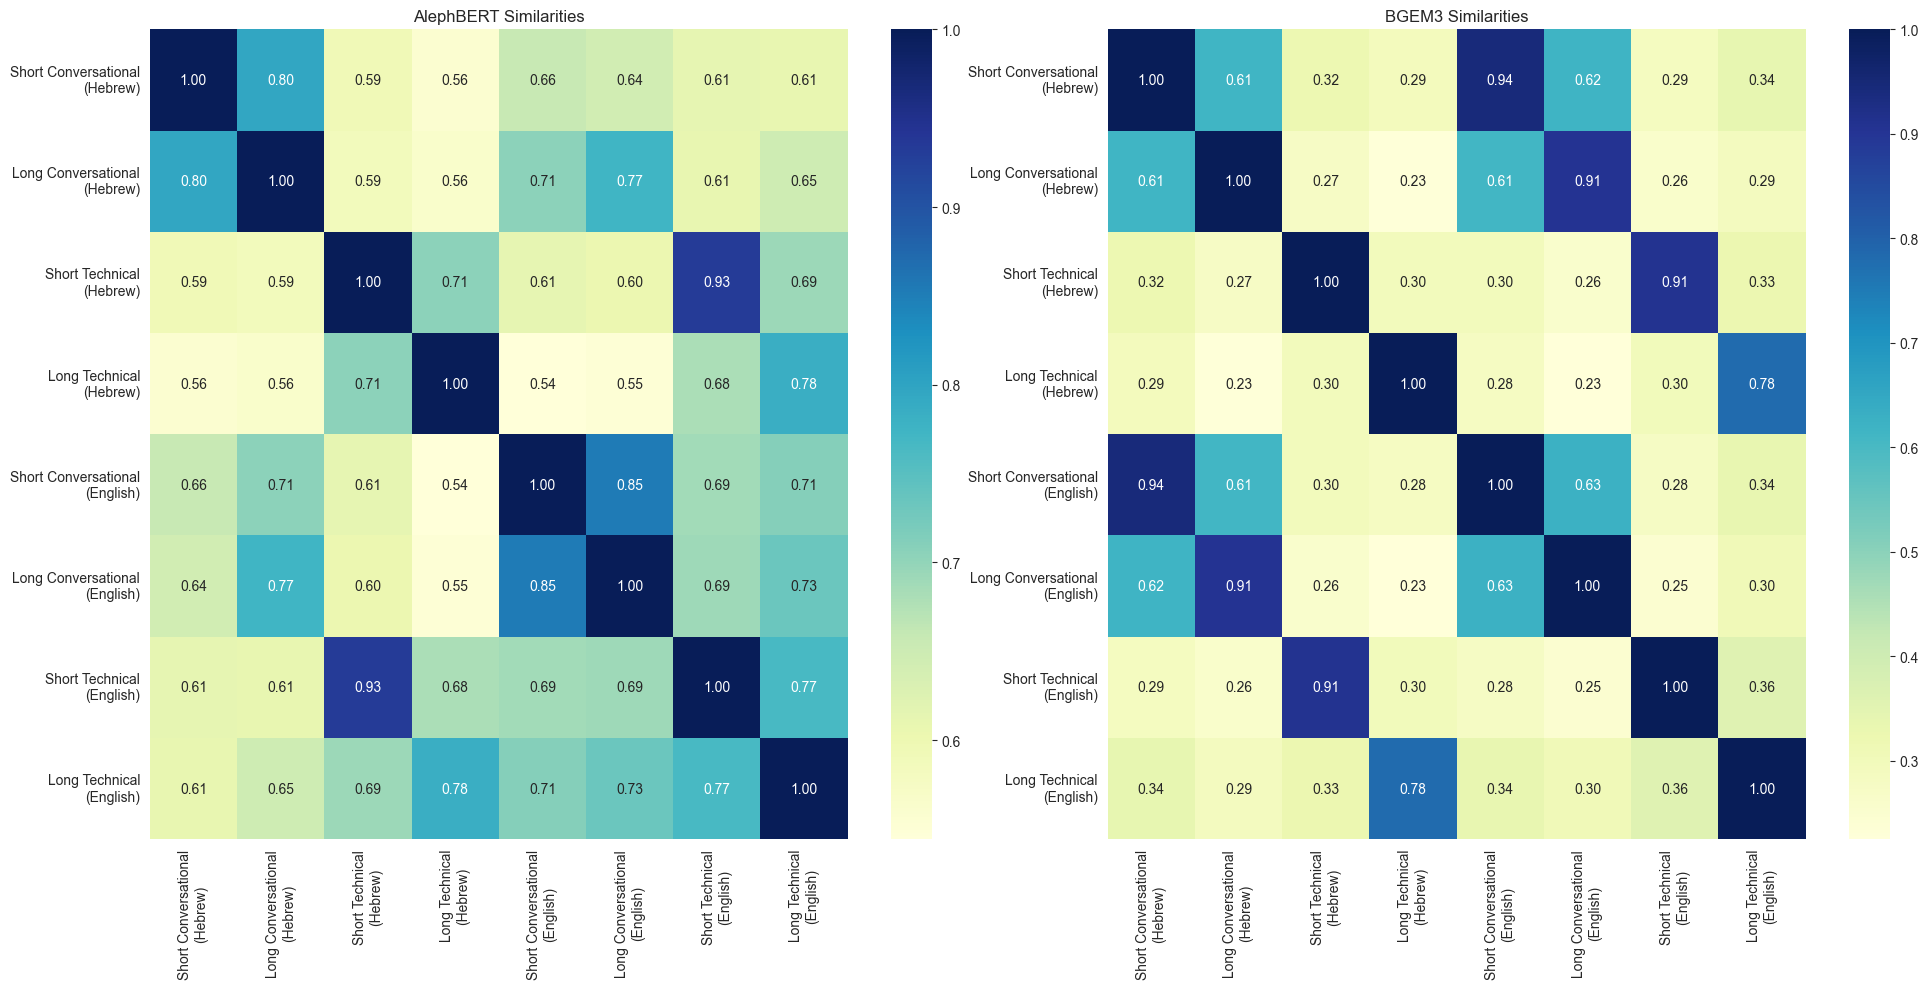

In [9]:
plt.figure(figsize=(20, 10))
for idx, (model_name, embedding_col) in enumerate([('AlephBERT', 'AlephBERT Embedding'), ('BGEM3', 'BGEM3 Embedding')], 1):
    similarities = np.zeros((len(texts), len(texts)))
    for i in range(len(texts)):
        for j in range(len(texts)):
            emb1 = df_results.iloc[i][embedding_col]
            emb2 = df_results.iloc[j][embedding_col]
            similarities[i, j] = compute_similarity(emb1, emb2)
    
    plt.subplot(1, 2, idx)
    sns.heatmap(similarities, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=[f"{t}\n({l})" for t, l in zip(text_types, languages)],
                yticklabels=[f"{t}\n({l})" for t, l in zip(text_types, languages)])
    plt.title(f'{model_name} Similarities')
    plt.tight_layout()

plt.show()

In [26]:
print("\nEmbedding Dimensions:")
print(f"AlephBERT: {df_results.iloc[0]['AlephBERT Embedding'].shape}")
print(f"BGEM3: {df_results.iloc[0]['BGEM3 Embedding'].shape}")


Embedding Dimensions:
AlephBERT: (1, 768)
BGEM3: (1024,)
